In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import scipy
import matplotlib.pyplot as plt
import numpy as np
from epi.models import Parameter, Model
from epi.util import pairplot

### 1. Define the V1Circuit model

In [56]:
W_lb = -3.
W_ub = 3.
E_lb = -2.
E_ub = 2.

sW = Parameter("sW", 1, lb=W_lb, ub=W_ub)
vW = Parameter("vW", 1, lb=W_lb, ub=W_ub)
dW = Parameter("dW", 1, lb=W_lb, ub=W_ub)
hW = Parameter("hW", 1, lb=W_lb, ub=W_ub)

E_constant = Parameter("E_constant", 1, lb=E_lb, ub=E_ub)
E_Pbias = Parameter("E_Pbias", 1, lb=0., ub=E_ub)
E_rule = Parameter("E_rule", 1, lb=0., ub=E_ub)
E_choice = Parameter("E_choice", 1, lb=E_lb, ub=E_ub)
E_light = Parameter("E_light", 1, lb=0., ub=E_ub)
sigma = Parameter("sigma", 1, lb=0., ub=0.5)

parameters = [sW, vW, dW, hW,
              E_constant, E_Pbias, E_rule, E_choice, E_light, sigma]

model = Model("SC_Circuit", parameters)

In [57]:
import tensorflow as tf
DTYPE = tf.float32

t_cue_delay = 1.2
t_choice = 0.3
t_post_choice = 0.3
t_total = t_cue_delay + t_choice + t_post_choice
dt = 0.024
t = np.arange(0.0, t_total, dt)
T = t.shape[0]

# input parameters
#E_constant = 0.
#E_Pbias = 0.5
#E_Prule = 1.
#E_Arule = 1.
#E_choice = -2.
#E_light = 1.
        
# set constant parameters
C = 2

theta = 0.05
beta = 0.5
tau = 0.09
#sigma = 0.2

def SC_sim(sW, vW, dW, hW, E_constant, E_Pbias, E_rule, E_choice, E_light, sigma):
    E_constant = E_constant[None,:,:,None,None]
    E_Pbias = E_Pbias[None,:,:,None,None]
    E_Prule = E_rule[None,:,:,None,None]
    E_Arule = E_rule[None,:,:,None,None]
    E_choice = E_choice[None,:,:,None,None]
    E_light = E_light[None,:,:,None,None]
    sigma = sigma[:,:,None,None]
    
    # inputs
    I_constant = E_constant * tf.ones((T, 1, 1, 4, 1), dtype=DTYPE)

    I_Pbias = np.zeros((T, 4))
    I_Pbias[t < T * dt] = np.array([1, 0, 0, 1])
    I_Pbias = I_Pbias[:,None,None,:,None]
    I_Pbias = E_Pbias * tf.constant(I_Pbias, dtype=DTYPE)

    I_Prule = np.zeros((T, 4))
    I_Prule[t < 1.2] = np.array([1, 0, 0, 1])
    I_Prule = I_Prule[:,None,None,:,None]
    I_Prule = E_Prule * tf.constant(I_Prule, dtype=DTYPE)

    I_Arule = np.zeros((T, 4))
    I_Arule[t < 1.2] = np.array([0, 1, 1, 0])
    I_Arule = I_Arule[:,None,None,:,None]
    I_Arule = E_Arule * tf.constant(I_Arule, dtype=DTYPE)

    I_choice = np.zeros((T, 4))
    I_choice[t > 1.2] = np.array([1, 1, 1, 1])
    I_choice = I_choice[:,None,None,:,None]
    I_choice = E_choice * tf.constant(I_choice, dtype=DTYPE)

    I_lightL = np.zeros((T, 4))
    #I_lightL[1.2 < t] = np.array([1, 1, 0, 0])
    I_lightL[np.logical_and(1.2 < t, t < 1.5)] = np.array([1, 1, 0, 0])
    I_lightL = I_lightL[:,None,None,:,None]
    I_lightL = E_light * tf.constant(I_lightL, dtype=DTYPE)

    I_lightR = np.zeros((T, 4))
    #I_lightR[1.2 < t] = np.array([0, 0, 1, 1])
    I_lightR[np.logical_and(1.2 < t, t < 1.5)] = np.array([0, 0, 1, 1])
    I_lightR = I_lightR[:,None,None,:,None]
    I_lightR = E_light * tf.constant(I_lightR, dtype=DTYPE)

    I_LP = I_constant + I_Pbias + I_Prule + I_choice + I_lightL
    I_LA = I_constant + I_Pbias + I_Arule + I_choice + I_lightL

    I = tf.concat((I_LP, I_LA), axis=2)

    N = 10
    Wrow1 = tf.stack([sW, vW, dW, hW], axis=2)
    Wrow2 = tf.stack([vW, sW, hW, dW], axis=2)
    Wrow3 = tf.stack([dW, hW, sW, vW], axis=2)
    Wrow4 = tf.stack([hW, dW, vW, sW], axis=2)
    
    W = tf.stack([Wrow1, Wrow2, Wrow3, Wrow4], axis=2)
    
    # initial conditions
    # M,C,4,1
    state_shape = (sW.shape[0], C, 4, N)
    v0 = 0.1 * tf.ones(state_shape, dtype=DTYPE)
    v0 = v0 #+ 0.005*tf.random.normal(v0.shape, 0., 1.)
    u0 = beta * tf.math.atanh(2 * v0 - 1) - theta

    v = v0
    u = u0
    v_t_list = [v]
    u_t_list = [u]
    for i in range(1, T):
        du = (dt / tau) * (-u + tf.matmul(W, v) + I[i] + sigma * tf.random.normal(state_shape, 0., 1.))
        #du = (dt / tau) * (-u + tf.matmul(W, v) + I[i] + sigma * w[i])
        u = u + du
        v = 1. * (0.5 * tf.tanh((u - theta) / beta) + 0.5)
        #v = eta[i] * (0.5 * tf.tanh((u - theta) / beta) + 0.5)
        v_t_list.append(v)
        u_t_list.append(u)

    u_t = tf.stack(u_t_list, axis=0)
    v_t = tf.stack(v_t_list, axis=0)
    return u_t, v_t

def SC_sim_wrap(z):
    sW = z[:,0][:,None]
    vW = z[:,1][:,None]
    dW = z[:,2][:,None]
    hW = z[:,3][:,None]
    E_constant = z[:,4][:,None]
    E_Pbias = z[:,5][:,None]
    E_rule = z[:,6][:,None]
    E_choice = z[:,7][:,None]
    E_light = z[:,8][:,None]
    sigma = z[:,9][:,None]
    return SC_sim(sW, vW, dW, hW, E_constant, E_Pbias, E_rule, E_choice, E_light, sigma)
    

def SC_acc(sW, vW, dW, hW, E_constant, E_Pbias, E_rule, E_choice, E_light, sigma):
    N = 200
    
    E_constant = E_constant[None,:,:,None,None]
    E_Pbias = E_Pbias[None,:,:,None,None]
    E_Prule = E_rule[None,:,:,None,None]
    E_Arule = E_rule[None,:,:,None,None]
    E_choice = E_choice[None,:,:,None,None]
    E_light = E_light[None,:,:,None,None]
    sigma = sigma[:,:,None,None]
    
    # inputs
    I_constant = E_constant * tf.ones((T, 1, 1, 4, 1), dtype=DTYPE)

    I_Pbias = np.zeros((T, 4))
    I_Pbias[t < T * dt] = np.array([1, 0, 0, 1])
    I_Pbias = I_Pbias[:,None,None,:,None]
    I_Pbias = E_Pbias * tf.constant(I_Pbias, dtype=DTYPE)

    I_Prule = np.zeros((T, 4))
    I_Prule[t < 1.2] = np.array([1, 0, 0, 1])
    I_Prule = I_Prule[:,None,None,:,None]
    I_Prule = E_Prule * tf.constant(I_Prule, dtype=DTYPE)

    I_Arule = np.zeros((T, 4))
    I_Arule[t < 1.2] = np.array([0, 1, 1, 0])
    I_Arule = I_Arule[:,None,None,:,None]
    I_Arule = E_Arule * tf.constant(I_Arule, dtype=DTYPE)

    I_choice = np.zeros((T, 4))
    I_choice[t > 1.2] = np.array([1, 1, 1, 1])
    I_choice = I_choice[:,None,None,:,None]
    I_choice = E_choice * tf.constant(I_choice, dtype=DTYPE)

    I_lightL = np.zeros((T, 4))
    #I_lightL[1.2 < t] = np.array([1, 1, 0, 0])
    I_lightL[np.logical_and(1.2 < t, t < 1.5)] = np.array([1, 1, 0, 0])
    I_lightL = I_lightL[:,None,None,:,None]
    I_lightL = E_light * tf.constant(I_lightL, dtype=DTYPE)

    I_lightR = np.zeros((T, 4))
    #I_lightR[1.2 < t] = np.array([0, 0, 1, 1])
    I_lightR[np.logical_and(1.2 < t, t < 1.5)] = np.array([0, 0, 1, 1])
    I_lightR = I_lightR[:,None,None,:,None]
    I_lightR = E_light * tf.constant(I_lightR, dtype=DTYPE)

    I_LP = I_constant + I_Pbias + I_Prule + I_choice + I_lightL
    I_LA = I_constant + I_Pbias + I_Arule + I_choice + I_lightL

    I = tf.concat((I_LP, I_LA), axis=2)
    Wrow1 = tf.stack([sW, vW, dW, hW], axis=2)
    Wrow2 = tf.stack([vW, sW, hW, dW], axis=2)
    Wrow3 = tf.stack([dW, hW, sW, vW], axis=2)
    Wrow4 = tf.stack([hW, dW, vW, sW], axis=2)
    
    W = tf.stack([Wrow1, Wrow2, Wrow3, Wrow4], axis=2)
    
    # initial conditions
    # M,C,4,N
    state_shape = (sW.shape[0], C, 4, N)
    v0 = 0.1 * tf.ones(state_shape, dtype=DTYPE)
    v0 = v0 #+ 0.005*tf.random.normal(v0.shape, 0., 1.)
    u0 = beta * tf.math.atanh(2 * v0 - 1) - theta

    v = v0
    u = u0
    for i in range(1, T):
        du = (dt / tau) * (-u + tf.matmul(W, v) + I[i] + sigma * tf.random.normal(state_shape, 0., 1.))
        u = u + du
        v = 1. * (0.5 * tf.tanh((u - theta) / beta) + 0.5)
        #v = eta[i] * (0.5 * tf.tanh((u - theta) / beta) + 0.5)

    p = tf.reduce_mean(tf.math.sigmoid(100.*(v[:,:,0,:]-v[:,:,3,:])), axis=2)
    return p


### 2. Define eps function using Euler

In [58]:
model.set_eps(SC_acc)

def accept_inds(T_x, means, stds):
    acc = np.array([np.logical_and(means[i] - 2*stds[i] < T_x[:,i], 
                    T_x[:,i] < means[i] + 2*stds[i]) for i in range(len(means))])
    return np.logical_and.reduce(acc, axis=0)
                          

In [63]:
num_keep = 10
M = 1000
zs = []
T_xs = []

p = 0.7
means = [p, 1-p]
stds = [0.025, 0.025]

num_found = 0
z = None
T_x = None
while (num_found < num_keep):
    _z = np.zeros((M, model.D), dtype=np.float32)
    for j in range(model.D):
        _z[:,j] = np.random.uniform(model.parameters[j].lb, model.parameters[j].ub, (M,))
    _T_x = model.eps(_z).numpy()
    #if z is None:
    #    plt.scatter(_T_x[:,0], 1-_T_x[:,1])
    #    plt.plot([0,1], [0,1], 'k-')
    #    plt.xlabel(r'$p_P$')
    #    plt.ylabel(r'$p_A$')
    #    break

    inds = accept_inds(_T_x, means, stds) 
    _z = _z[inds, :]
    _T_x = _T_x[inds, :]
    num_found += _z.shape[0]

    if (z is None):
        z = _z
        T_x = _T_x
    else:
        z = np.concatenate((z, _z), axis=0)
        T_x = np.concatenate((T_x, _T_x), axis=0)
    print('%d/%d\r' % (num_found, num_keep), end='')

    num_found = z.shape[0]

# reduce to num_keep
z = z[:num_keep]
T_x = T_x[:num_keep]

num_plot = 500
fontsize = 20


In [60]:
_lb = np.array([p.lb[0] for p in model.parameters])
_ub = np.array([p.ub[0] for p in model.parameters])

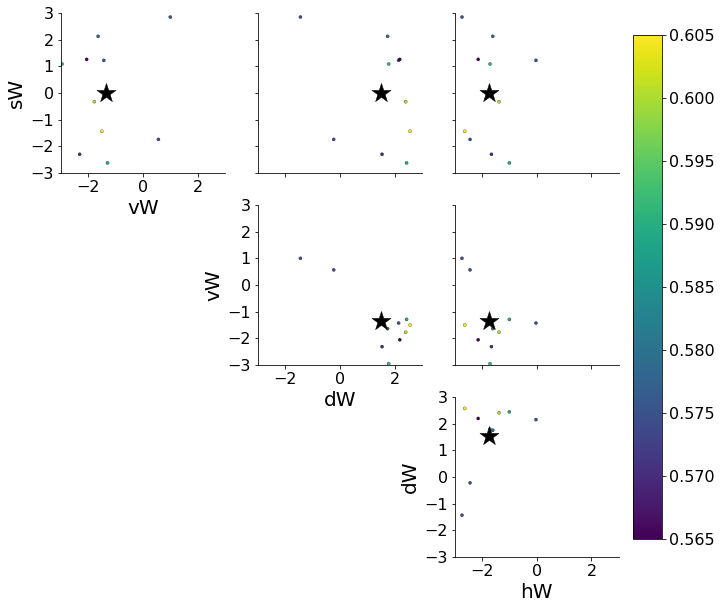

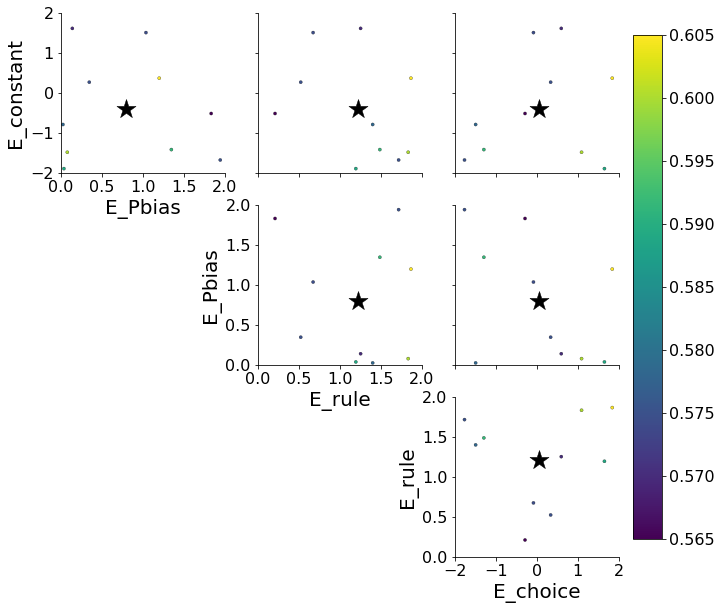

In [61]:
z_labels = [p.name for p in model.parameters]
z_star = np.mean(z, axis=0)[None,:]

inds_list = [range(4), range(4, 8)]
for inds in inds_list:
    _z_labels = [z_labels[ind] for ind in inds]
    fig = pairplot(z[:num_plot], inds, _z_labels,
                   fontsize=fontsize, figsize=(10,10), starred=z_star,
                   lb=_lb, ub=_ub, c = T_x[:,0])


m 0
sW 1.2672477
vW -2.056189
dW 2.1915848
hW -2.142397
E_constant -0.50934696
E_Pbias 1.8320663
E_rule 0.21039635
E_choice -0.28638777
E_light 0.9711383
sigma 0.18414181
[0.565 0.4  ]
c 1


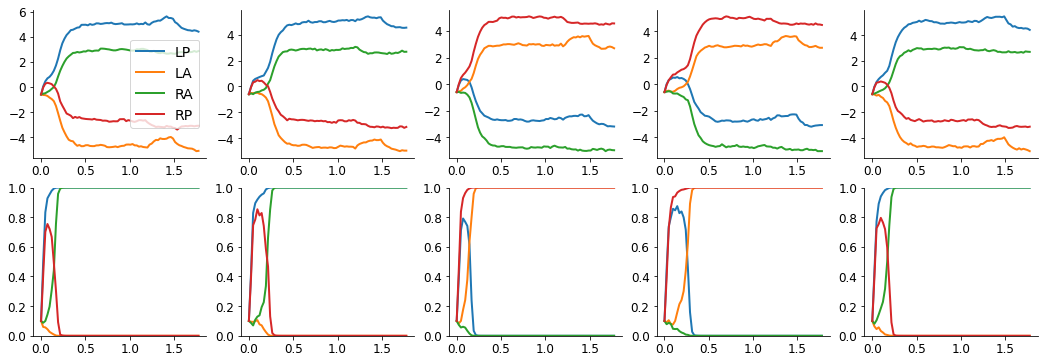

c 2


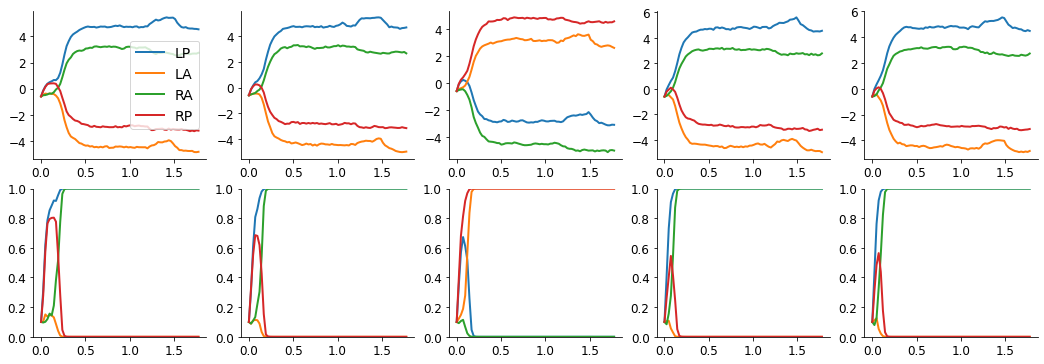

m 1
sW 1.2296721
vW -1.4278159
dW 2.1485357
hW -0.028991777
E_constant -1.6724074
E_Pbias 1.9428772
E_rule 1.7162826
E_choice -1.7612087
E_light 1.7700609
sigma 0.22362044
[0.5751392  0.43197915]
c 1


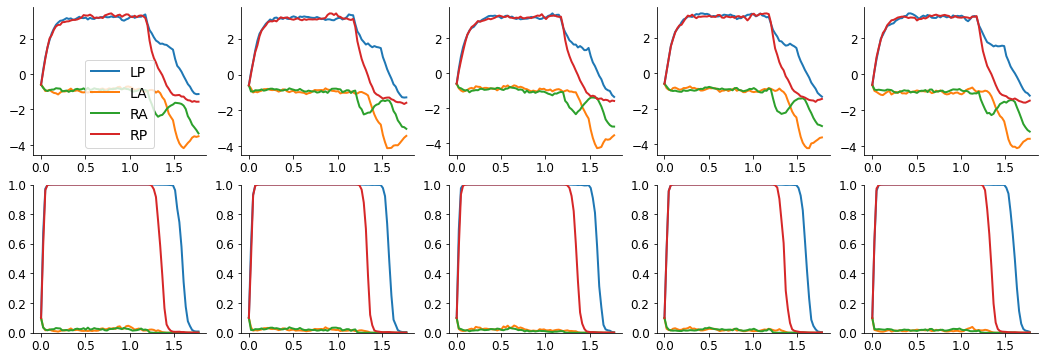

c 2


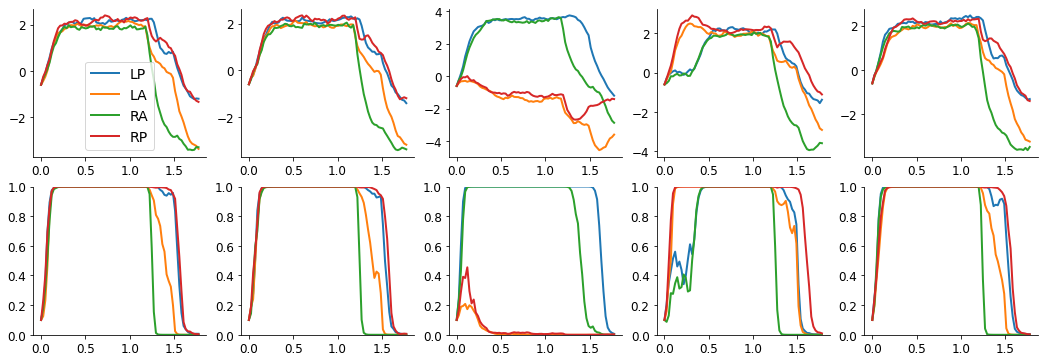

m 2
sW -1.736877
vW 0.5681231
dW -0.22378373
hW -2.439173
E_constant 1.514979
E_Pbias 1.0372043
E_rule 0.6743736
E_choice -0.08064317
E_light 0.11237213
sigma 0.33061302
[0.57443136 0.4350032 ]
c 1


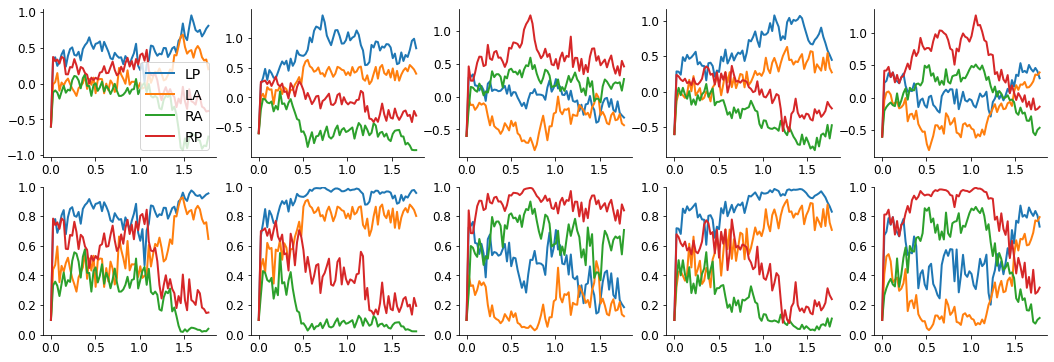

c 2


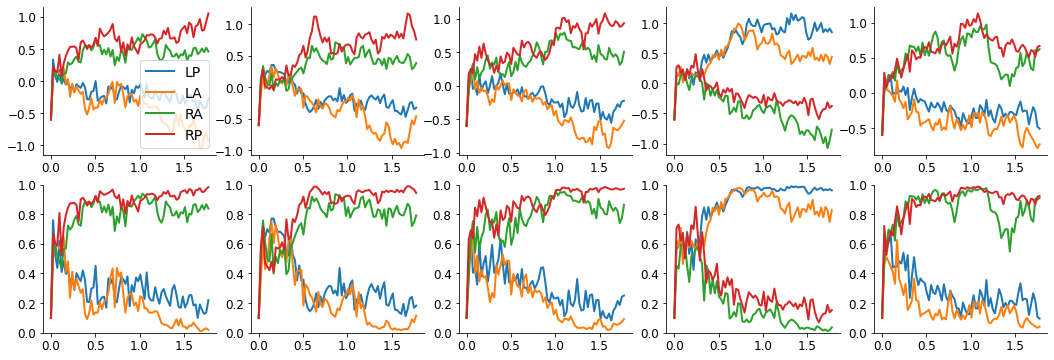

m 3
sW 2.1314397
vW -1.6367419
dW 1.7466038
hW -1.6092967
E_constant -0.784574
E_Pbias 0.025444923
E_rule 1.4001257
E_choice -1.4904749
E_light 1.6489621
sigma 0.06262051
[0.5782384  0.41972363]
c 1


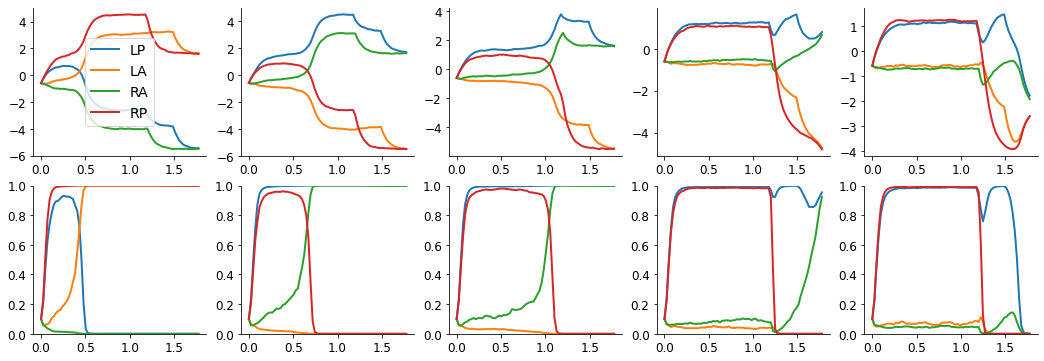

c 2


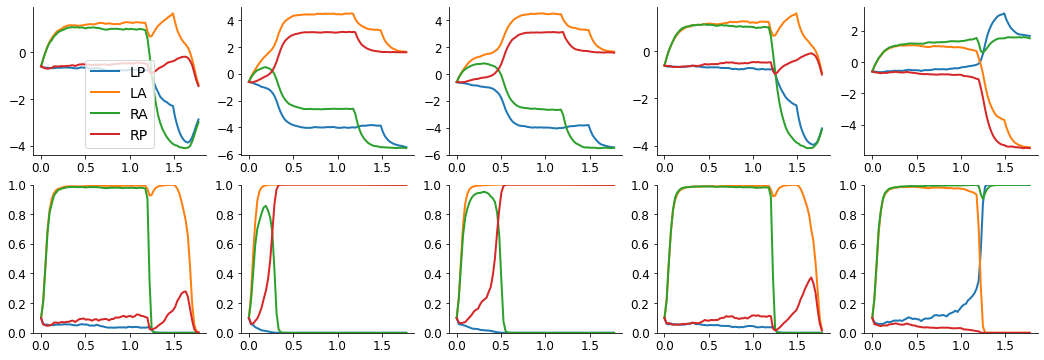

m 4
sW -1.4322376
vW -1.5017041
dW 2.5686202
hW -2.6333876
E_constant 0.3749019
E_Pbias 1.1992209
E_rule 1.8666997
E_choice 1.8398043
E_light 1.1415782
sigma 0.45330855
[0.605 0.385]
c 1


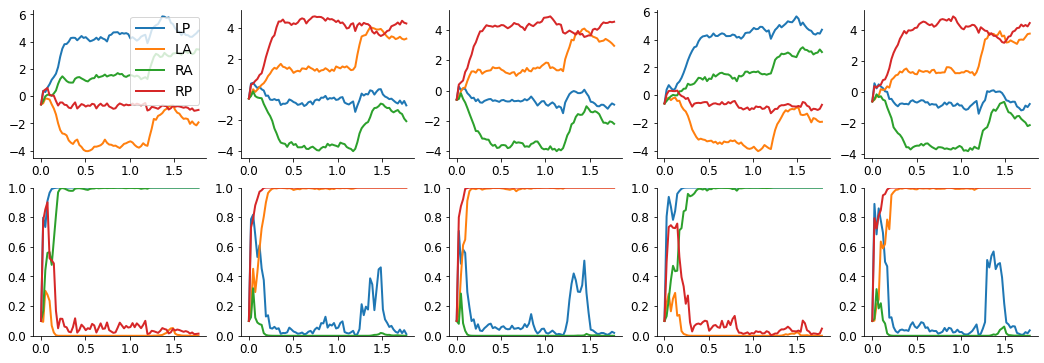

c 2


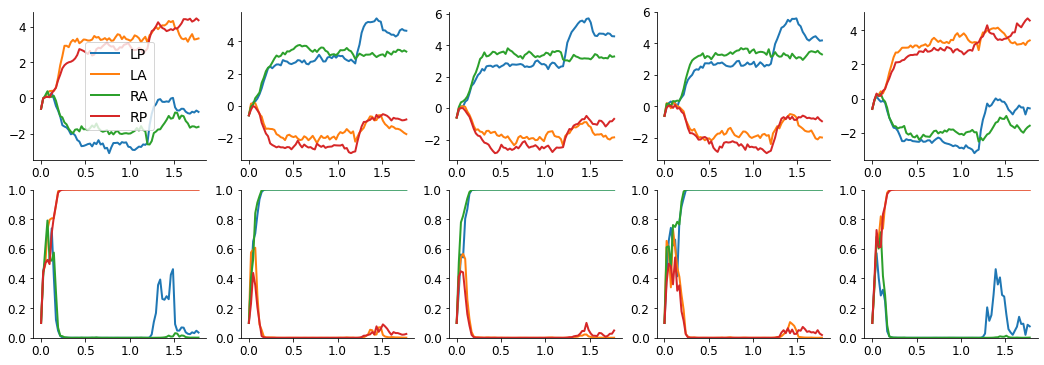

In [62]:
u_t, v_t = SC_sim_wrap(z)
neuron_labels = ['LP', 'LA', 'RA', 'RP']
J = 5
for m in range(5):
    print('m', m)
    for i in range(model.D):
        print(model.parameters[i].name, z[m,i])
    print(T_x[m])
    for c in range(2):
        print('c', c+1)
        fig, axs = plt.subplots(2, J, figsize=(18,6))
        for j in range(J):
            for i in range(4):
                axs[0,j].plot(t, u_t[:,m,c,i,j], label=neuron_labels[i])
                axs[1,j].plot(t, v_t[:,m,c,i,j], label=neuron_labels[i])
                axs[1,j].set_ylim([0,1])
                
        axs[0,0].legend()
        plt.show()


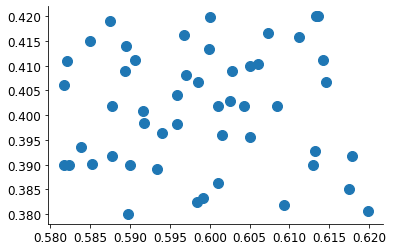

In [131]:
plt.scatter(T_x[:,0], T_x[:,1])

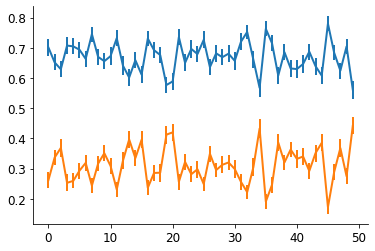

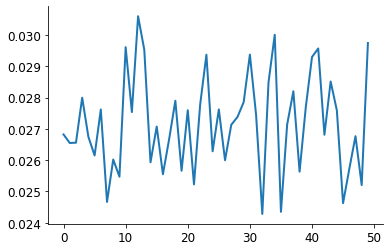

In [132]:
z_rand = np.array([np.random.normal(z_star[0,i], 1., (M_interp,)) for i in range(4)], dtype=np.float32).T
T_x_rands = []
N_samp = 250
for i in range(N_samp):
    T_x_rands.append(model.eps(z_rand))
    
T_x_rands = np.stack(T_x_rands, axis=0)
p_mean = np.mean(T_x_rands, axis=0)
p_std = np.std(T_x_rands, axis=0)
plt.figure()
plt.errorbar(np.arange(p_mean.shape[0]), p_mean[:,0], p_std[:,0])
plt.errorbar(np.arange(p_mean.shape[0]), p_mean[:,1], p_std[:,1])
plt.show()

plt.figure()
plt.plot(np.arange(p_mean.shape[0]), p_std[:,0])
plt.show()


In [106]:
T_x_star = model.eps(z_star)
print(T_x_star)

M_interp = 50
z_interp = np.array([np.linspace(0., z_star[0,i], M_interp) for i in range(4)], dtype=np.float32).T

tf.Tensor([[0.9965279  0.01305532]], shape=(1, 2), dtype=float32)


In [107]:
T_x_interps = []
N_samp = 250
for i in range(N_samp):
    T_x_interps.append(model.eps(z_interp))
    
T_x_interps = np.stack(T_x_interps, axis=0)
print(T_x_interps.shape)

(250, 50, 2)


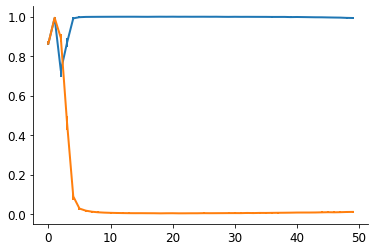

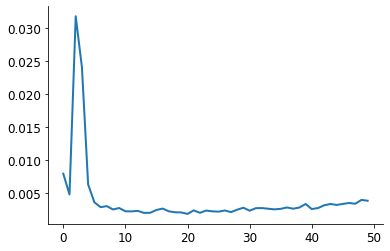

In [108]:
p_mean = np.mean(T_x_interps, axis=0)
p_std = np.std(T_x_interps, axis=0)
plt.figure()
plt.errorbar(np.arange(p_mean.shape[0]), p_mean[:,0], p_std[:,0])
plt.errorbar(np.arange(p_mean.shape[0]), p_mean[:,1], p_std[:,1])
plt.show()

plt.figure()
plt.plot(np.arange(p_mean.shape[0]), p_std[:,0])
plt.show()